<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [92]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
SEED = 42

In [3]:
train_df = pd.read_csv('data/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [8]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df, train_df['label'], random_state=SEED)

# EDA

### 1. Looking at the dataset (head, info, describe, columns) 

For subsequent analysis I will use only (train_texts, y_train). </br>
Let's look at the data by printing first 10 rows and descriptive statistics

#### 1.1 Let's look at the data by printing its head

In [9]:
train_texts.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
61809,0,"Not drafting Reed, Olsen, or Gronk at where th...",tykulton,fantasyfootball,2,-1,-1,2016-12,2016-12-21 23:35:45,"What is your ""one rule"" for the draft next sea..."
509675,1,Don't you just love the FPTP.,Gardengran,canada,1,1,0,2016-01,2016-01-10 01:51:50,And in Canada 27% voted for the Liberals so th...
132418,1,"The question is why Chief Delphi, TBA, and the...",BellLabs,FRC,11,-1,-1,2016-11,2016-11-23 16:13:51,Why am I not surprised anymore.
183253,0,"easier gold farm is warrior Bolster, Target Du...",Nickster357a,hearthstone,1,1,0,2016-09,2016-09-15 00:41:22,lol been playing this for an hour just farming...
190605,1,What a cuck!,somenbjorn,ShitWehraboosSay,2,2,0,2016-07,2016-07-27 15:28:02,"At least Sparks, if that's even his real name,..."
169435,1,"Nice choice of pictures, did they include him ...",shiinamachi,formula1,6,-1,-1,2016-12,2016-12-17 12:51:26,Who else but @Max33Verstappen
799320,0,When people complain to me about something som...,VR46,AskReddit,3,3,0,2014-10,2014-10-26 06:22:10,What is something that drives you crazy that n...
675529,0,Added to original post,d72x,beermoney,4,4,0,2015-04,2015-04-05 17:40:40,That is ridiculous but proof?
823896,0,"If it makes you feel better, these aren't real...",easterplatypus,Guildwars2,4,4,0,2014-01,2014-01-14 16:07:25,""" minipet slot added"" ""reduced ammount of silk..."
1005808,1,How am I gonna beat my wife without bruising h...,KnightKrawler,worldnews,2,2,0,2010-01,2010-01-02 13:05:07,At least put islam down with truth not with bu...


#### 1.2 Descriptive statistics

In [10]:
train_texts.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
label,758079.0,NaN,NaN,NaN,0.499579,0.5,0.0,0.0,0.0,1.0,1.0
comment,758079,724268,You forgot the,1081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,758079,245701,Biffingston,625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subreddit,758079,13254,AskReddit,49381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,758079.0,NaN,NaN,NaN,6.893258,48.154597,-312.0,1.0,2.0,4.0,9070.0
ups,758079.0,NaN,NaN,NaN,5.519294,41.488481,-312.0,0.0,1.0,3.0,4909.0
downs,758079.0,NaN,NaN,NaN,-0.146018,0.353124,-1.0,0.0,0.0,0.0,0.0
date,758079,96,2016-12,40046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_utc,758079,754609,2016-04-08 05:34:23,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parent_comment,758079,741399,me irl,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.3 Columns

As soon as we deleted rows with omitted comments we don't have missing values in the dataset.
* **label** - label 0/1 - non-sarcastic/sarcastic
* **comment** - comment itself. Later we will be able to predict which of them are sarcastic and which are not. </br>
    * find the number of words in each sentence and compare length distributions for both sarcastic and non-sarcastic comments
    * score & length & label interaction  
    * can try to expand connotations like don'tlike don't
* **author** - author's nickname
    * find unique values 
    * find counts
* **subreddit** - name of the subreddit. A subreddit is a specific online community, and the posts associated with it, on the social media website Reddit. Subreddits are dedicated to a particular topic that people write about, and they’re denoted by /r/, followed by the subreddit’s name, e.g., /r/gaming.
    * find unique values
    * calculate the "sarcasticness" of the top subreddits
* **score** - comment's score. Which is simply the number of upvotes minus the number of downvotes.
* **ups** and **downs** - number of ups and downs respectively
    * look for the errors in the data (for example, min value for ups is -261, which is strange)
* **date** - year and month when the comment was written
* **created_utc** - date + day, hours, minutes, secons
    * dependency between day of the week and/or hour of the day and the sarcasm?
* **parent_comment**

#### 1.4 Data instabilities

In [11]:
correct_score = sum(train_texts['score'] == train_texts['ups'] - train_texts['downs'])
print(f"The score is correct only for {correct_score} number of rows out of {train_texts.shape[0]}")

The score is correct only for 652046 number of rows out of 758079


Data instabilities noticed: </br>
* score, ups and downs behave strangely. Score must be equal to ups - downs

#### 1.5 Dealing with missing data and outliers

Currently, this is out of scope

### 2. Target variable analysis

C:\Users\ryblo\Documents\projects\experiments\ods_mlcourse_ai\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

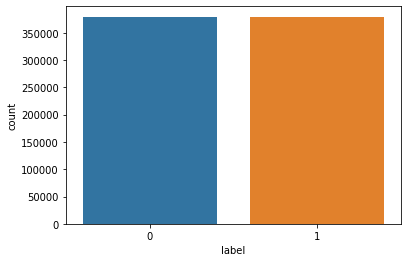

In [12]:
sns.countplot('label',data=train_texts)

The train dataset is balanced, thus we can use accuracy score without a second thought

### 3. Feature Analysis

#### 3.1 Looking at columns and determining feature types 

In [13]:
train_texts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758079 entries, 61809 to 121960
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   label           758079 non-null  int64 
 1   comment         758079 non-null  object
 2   author          758079 non-null  object
 3   subreddit       758079 non-null  object
 4   score           758079 non-null  int64 
 5   ups             758079 non-null  int64 
 6   downs           758079 non-null  int64 
 7   date            758079 non-null  object
 8   created_utc     758079 non-null  object
 9   parent_comment  758079 non-null  object
dtypes: int64(4), object(6)
memory usage: 79.7+ MB


We have 10 columns: 1 label, 3 numerical (score, ups, downs) and 6 strings/timstamps. 

#### 3.2 Summarizing data and showing some statistics:

In [14]:
train_texts.describe(include=["object", "bool"])

,comment,author,subreddit,date,created_utc,parent_comment
count,758079,758079,758079,758079,758079,758079
unique,724268,245701,13254,96,754609,741399
top,You forgot the,Biffingston,AskReddit,2016-12,2016-04-08 05:34:23,me irl
freq,1081,625,49381,40046,4,208


Some thoughts:
* Almost all the comments are unique
* One third of authors are unique
* Approximatelly 13 000 subreddits are in the dataset
* Datasets spans 96 months = 8 years of observations

In [15]:
for label, dataset in train_texts.groupby('label'):
    print(f"\nFor label {label} the object data statistics is:\n")
    print(dataset.describe(include=['object', 'bool']))


For label 0 the object data statistics is:

       comment       author  subreddit     date          created_utc  \
count   379359       379359     379359   379359               379359   
unique  361591       210093      11374       96               378474   
top        Yes  Biffingston  AskReddit  2016-12  2016-05-18 14:14:51   
freq       303          325      29528    23627                    3   

       parent_comment  
count          379359  
unique         372922  
top            me irl  
freq              184  

For label 1 the object data statistics is:

               comment       author  subreddit     date          created_utc  \
count           378720       378720     378720   378720               378720   
unique          365459       211242       8039       96               377900   
top     You forgot the  Biffingston  AskReddit  2016-12  2016-04-08 05:34:23   
freq              1081          300      19853    16419                    4   

       parent_comment  
coun

Separate statistics for 0 and 1 labels doesn't look different

In [16]:
train_texts.describe()

,label,score,ups,downs
count,758079.000000,758079.000000,758079.000000,758079.000000
mean,0.499579,6.893258,5.519294,-0.146018
std,0.500000,48.154597,41.488481,0.353124
min,0.000000,-312.000000,-312.000000,-1.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,2.000000,1.000000,0.000000
75%,1.000000,4.000000,3.000000,0.000000
max,1.000000,9070.000000,4909.000000,0.000000


#### 3.3 Analysis

##### 3.3.1 Comment

Let's add new variable which will denote the length of the comment

In [17]:
train_texts['length'] = [len(comment.split()) for comment in train_texts['comment']]

In [18]:
train_texts[['comment', 'length']].head()

,comment,length
61809,"Not drafting Reed, Olsen, or Gronk at where th...",11
509675,Don't you just love the FPTP.,6
132418,"The question is why Chief Delphi, TBA, and the...",14
183253,"easier gold farm is warrior Bolster, Target Du...",10
190605,What a cuck!,3


In [19]:
train_texts['length'].describe().T

count    758079.000000
mean         10.468164
std          10.705932
min           1.000000
25%           5.000000
50%           9.000000
75%          14.000000
max        2222.000000
Name: length, dtype: float64

In [20]:
print(f"0.025 quantile of comment's length is equal to {train_texts['length'].quantile(0.025)}")
print(f"0.975 quantile of comment's length is equal to {train_texts['length'].quantile(0.975)}")

0.025 quantile of comment's length is equal to 1.0
0.975 quantile of comment's length is equal to 30.0


It looks like we have some outliers in the length of the comment column. </br>
For the purpose of visualization I'm going to filter out some outliers. In future whether it will be helpful for classification or not

In [21]:
cleaned_train_texts = train_texts[train_texts['length'] <= train_texts['length'].quantile(0.975)] 

Now we can compare the length distributions for 0/1 labels

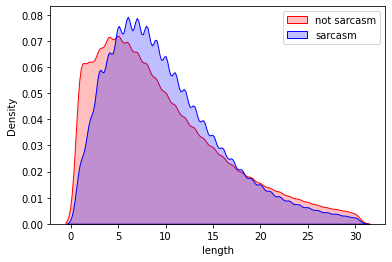

In [22]:
g = sns.kdeplot(cleaned_train_texts[cleaned_train_texts["label"]==0]["length"], color="red", shade=True)
g = sns.kdeplot(cleaned_train_texts[cleaned_train_texts["label"]==1]["length"], color="blue", shade=True)
g = g.legend(["not sarcasm", "sarcasm"])

<AxesSubplot:ylabel='Frequency'>

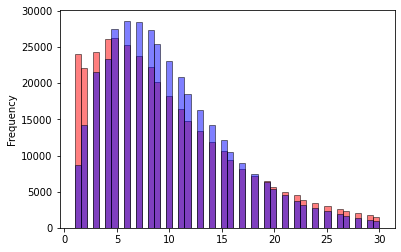

In [23]:
cleaned_train_texts[cleaned_train_texts["label"]==0]["length"].plot.hist(bins=50, alpha = 0.5, edgecolor="black", color="red")
cleaned_train_texts[cleaned_train_texts["label"]==1]["length"].plot.hist(bins=50, alpha = 0.5, edgecolor="black", color="blue")

'length' feature may not be the informative one. But maybe we can split it into bins - into three intervals: [1, 5), [5, 20), [21, 30] and it will improve the accuracy score.

##### 3.3.2 Score

In [24]:
cleaned_train_texts['score'].describe()

count    739572.000000
mean          6.900841
std          48.346139
min        -312.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        9070.000000
Name: score, dtype: float64

'score' feature also has outliers. We ought to get rid of them

In [25]:
print(f"0.025 quantile of comment's score is equal to {cleaned_train_texts['score'].quantile(0.025)}")
print(f"0.975 quantile of comment's score is equal to {cleaned_train_texts['score'].quantile(0.975)}")

0.025 quantile of comment's score is equal to -4.0
0.975 quantile of comment's score is equal to 41.0


In [26]:
cleaned_train_texts = cleaned_train_texts[(cleaned_train_texts['score'] <= cleaned_train_texts['score'].quantile(0.975)) & 
                                  (cleaned_train_texts['score'] >= cleaned_train_texts['score'].quantile(0.025))] 

<AxesSubplot:ylabel='Frequency'>

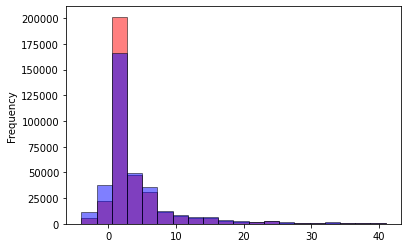

In [27]:
cleaned_train_texts[(cleaned_train_texts["label"]==0)]["score"].plot.hist(bins=20, alpha=0.5, edgecolor="black", color="red")
cleaned_train_texts[(cleaned_train_texts["label"]==1)]["score"].plot.hist(bins=20, alpha=0.5, edgecolor="black", color="blue")

'score' feature also seems to have minor effect on the value of the 'label' column

##### 3.3.3 Subreddits

In [28]:
subreddit_unique = train_texts['subreddit'].unique()
print(len(subreddit_unique))

13254


The number of unique subreddits is 13254


In [29]:
top_subreddits = pd.DataFrame(
    train_texts.groupby('subreddit')['label'].agg(['count', 'mean'])
                                             .round(2)
                                             .sort_values(by='count', ascending=False)
                                             .head(200)).rename(columns={"mean":"sarcasticness"})

In [30]:
top_subreddits.T

subreddit,AskReddit,politics,worldnews,leagueoflegends,pcmasterrace,funny,news,pics,todayilearned,nba,...,italy,reactiongifs,nintendo,buildapc,OkCupid,vancouver,roosterteeth,darksouls3,ClashOfClans,food
count,49381.0,29601.00,19661.00,15716.00,14273.00,13465.00,12686.0,12177.00,10635.00,10611.00,...,593.00,593.00,592.00,591.00,585.00,584.00,582.00,580.00,580.00,579.00
sarcasticness,0.4,0.61,0.64,0.54,0.57,0.45,0.6,0.48,0.55,0.53,...,0.58,0.45,0.53,0.31,0.48,0.57,0.53,0.41,0.57,0.38


We can see that the percentage of sarcastic comments differs from subreddit to subreddit. </br>
This feature can be useful in prediction.

### 4. Feature engineering

This step will be skipped right now to build baseline model. After the estimation of baseline model performance we will return to feature engineering

### 5. Predictive modelling

Splitting data again with the same <code>random_seed</code> to get handy variables to pass to <code>fit()</code> method

In [31]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comment'], train_df['label'], random_state=SEED)

#### 5.0 Baseline model (TF-IDF + LogReg) - parameter tuning - dataset cleaning - pipeline

In [32]:
tf_idf = TfidfVectorizer()
X = tf_idf.fit_transform(train_texts)
X_valid = tf_idf.transform(valid_texts)
print(X.shape)

(758079, 143104)


In [33]:
log_reg = LogisticRegression(random_state=SEED, n_jobs=-1)

In [34]:
log_reg.fit(X, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [35]:
y_pred = log_reg.predict(X_valid)

In [36]:
acc_baseline = accuracy_score(y_pred=y_pred, y_true=y_valid)
print(f"Accuracy for baseline model is {acc_baseline.round(3)}")

Accuracy for baseline model is 0.692


#### 5.1 Baseline model (TF-IDF + LogReg) - parameter tuning - dataset cleaning + pipeline

In [37]:
tf_idf = TfidfVectorizer()
log_reg = LogisticRegression(random_state=SEED, n_jobs=-1)
pipeline = Pipeline([('tf_idf', tf_idf), ('log_reg', log_reg)])

In [38]:
pipeline.fit(train_texts, y_train)

Pipeline(steps=[('tf_idf', TfidfVectorizer()),
                ('log_reg', LogisticRegression(n_jobs=-1, random_state=42))])

In [39]:
y_pred = pipeline.predict(valid_texts)

In [40]:
acc_baseline = accuracy_score(y_pred=y_pred, y_true=y_valid)
print(f"Accuracy for baseline model is {acc_baseline.round(3)}")

Accuracy for baseline model is 0.692


Accuracy for baseline model is 0.69. The datset for training was taken as it is. Hyperparameters weren't tuned.


#### 5.2 Baseline model (TF-IDF + LogReg) + dataset cleaning - parameter tuning + pipeline

In [41]:
pipeline.fit(cleaned_train_texts['comment'], cleaned_train_texts['label'])
y_pred_cleaned = pipeline.predict(valid_texts)
acc_cleaned = accuracy_score(y_pred=y_pred_cleaned, y_true=y_valid)
print(f"Accuracy for baseline model with cleaned dataset is {acc_cleaned.round(3)}")

Accuracy for baseline model with cleaned dataset is 0.691


Accuracy for cleaned dataset is still 0.69. </br>
* removed comments with length > 30 words
* removed comments with scores that is less than -4 and more than 41

Hyperparameters weren't tuned.


#### 5.3 Baseline model (TF-IDF + LogReg) - dataset cleaning + parameter tuning + pipeline

In [42]:
X = train_df['comment']
y = train_df['label']

In [43]:
tf_idf = TfidfVectorizer()
log_reg = LogisticRegression(random_state=SEED, n_jobs=-1)
pipeline = Pipeline([('tf_idf', tf_idf), ('log_reg', log_reg)])

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [45]:
param_grid = {
    "tf_idf__max_df": (0.25, 0.5, 0.75),
    "tf_idf__ngram_range": [(1,1), (1,2), (1,3)],
    "log_reg__C": np.logspace(-1, 1, 100),
}
search = GridSearchCV(pipeline, param_grid, cv=skf, n_jobs=-1, verbose=3)

In [46]:
# search.fit(X, y)

Parameter tuning takes a lot of time for such huge dataset. </br>
Emperically the best performance is provided with next parameters:

In [47]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
log_reg = LogisticRegression(random_state=SEED, n_jobs=-1)
pipeline = Pipeline([('tf_idf', tf_idf), ('log_reg', log_reg)])

In [48]:
pipeline.fit(train_texts, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=100000, ngram_range=(1, 2))),
                ('log_reg', LogisticRegression(n_jobs=-1, random_state=42))])

In [49]:
y_pred = pipeline.predict(valid_texts)

In [50]:
acc_baseline = accuracy_score(y_pred=y_pred, y_true=y_valid)
print(f"Accuracy for tuned model is {acc_baseline.round(3)}")

Accuracy for tuned model is 0.722


#### 5.4 Explaining model predictions

In [200]:
# !pip install eli5

In [132]:
import eli5

In [210]:
eli5.show_weights(pipeline, top=100)

C:\Users\ryblo\Documents\projects\experiments\ods_mlcourse_ai\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+9.311,yes because
+8.252,clearly
+8.105,obviously
+7.736,totally
+7.288,yeah because
+6.867,because
+6.008,how dare
+5.719,good thing
+5.539,right because
+5.130,duh


From feature importances we can see 
* why using stopwords actually can reduce the accuracy - stopwords play important role in prediction sarcasm
* using bigrams improves the accuracy (using trigrams makes accuracy slightly worse)
* 100 000 features is enough for Tf-Idf vectorizer

#### 5.5 Adding subreddits as a new feature

In [122]:
train, valid, y_train, y_valid = train_test_split(train_df.drop('label', axis=1), train_df['label'], random_state=SEED)

In [123]:
comments_train = train['comment']
comments_valid = valid['comment']
subreddits_train = train['subreddit']
subreddits_valid = valid['subreddit']

In [124]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
X_train = tf_idf.fit_transform(comments_train)
X_valid = tf_idf.transform(comments_valid)
print(X_train.shape)

(758079, 100000)


In [125]:
ohe = OneHotEncoder(handle_unknown='ignore')
subreddit_ohe_train = ohe.fit_transform(np.array(subreddits_train).reshape(-1, 1))
subreddit_ohe_valid = ohe.transform(np.array(subreddits_valid).reshape(-1, 1))

In [126]:
X = sparse.hstack([X_train, subreddit_ohe_train])
X_val = sparse.hstack([X_valid, subreddit_ohe_valid])

In [127]:
log_reg = LogisticRegression(random_state=SEED, n_jobs=-1)

In [128]:
log_reg.fit(X, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [129]:
y_pred = log_reg.predict(X_val)

In [130]:
acc_baseline = accuracy_score(y_pred=y_pred, y_true=y_valid)
print(f"Accuracy for tuned model is {acc_baseline.round(3)}")

Accuracy for tuned model is 0.724


The accuracy of the model which incorporates comments and subreddits to predict sarcasm is 0.724. </br>
It is better, but only by 0.002

Showing weights will be trickier this time. We should pass feature names.

In [151]:
feature_names_comments = tf_idf.get_feature_names_out()
feature_names_subreddits = ohe.get_feature_names_out()
feature_names = feature_names_comments.tolist() + feature_names_subreddits.tolist()

In [155]:
eli5.show_weights(log_reg, top=200, feature_names=feature_names)

Weight?,Feature
+12.600,yes because
+8.673,yeah because
+7.041,good thing
+7.020,gee
+6.883,obviously
+6.868,clearly
+6.864,because
+6.721,sexist
+6.547,but thought
+6.503,totally


In top-200 the most important features only 4 are subreddit names - not too much

#### 5.6 Reducing the test size

When dealing with huge datasets like this we can take advantage of its size and make test size equal to 5% of the whole data. </br> 
We will still have plenty of examples for test (50 000), but we will have more data to train

In [170]:
train, valid, y_train, y_valid = train_test_split(train_df.drop('label', axis=1), train_df['label'], random_state=SEED, test_size=0.05)

In [171]:
comments_train = train['comment']
comments_valid = valid['comment']
subreddits_train = train['subreddit']
subreddits_valid = valid['subreddit']

In [172]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
X_train = tf_idf.fit_transform(comments_train)
X_valid = tf_idf.transform(comments_valid)
print(X_train.shape)

(960234, 100000)


In [173]:
ohe = OneHotEncoder(handle_unknown='ignore')
subreddit_ohe_train = ohe.fit_transform(np.array(subreddits_train).reshape(-1, 1))
subreddit_ohe_valid = ohe.transform(np.array(subreddits_valid).reshape(-1, 1))

In [174]:
X = sparse.hstack([X_train, subreddit_ohe_train])
X_val = sparse.hstack([X_valid, subreddit_ohe_valid])

In [175]:
log_reg = LogisticRegression(random_state=SEED, n_jobs=-1)

In [176]:
log_reg.fit(X, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [177]:
y_pred = log_reg.predict(X_val)

In [178]:
acc_baseline = accuracy_score(y_pred=y_pred, y_true=y_valid)
print(f"Accuracy for tuned model is {acc_baseline.round(3)}")

Accuracy for tuned model is 0.726


The improvement in accuracy is again 0.002 -> 0.726, which is not much, but still an improvement

# TODO
* Check confusion matrix
* Add new features from the EDA part of this notebook
* Try to make dataset cleaning work
* Try using Universal Sentence Encoder to get text features with random projection matrix to get embeddings instead of tf-idf

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions